<a href="https://colab.research.google.com/github/buwituze/pre-consultation-agent/blob/main/typhoid_pred_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Typhoid Fever Prediction Model
## Pre-consultation and triage Assistant

This notebook trains a machine learning model that take the patient's symptoms and history and predict if they have typhoid fever and the severity status.

**Model Performance:** 89.5% accuracy  
**Training Dataset:** 31,087 patients  
**Algorithm:** Gradient Boosting Classifier

## 1. Install & Import Dependencies

In [1]:
# !pip install -q pandas numpy scikit-learn

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## 2. Mount Google Drive & Set Paths

This will mount your Google Drive and set up paths to access your dataset and save the model.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully


In [4]:
# Set paths
import os

capstone_folder = '/content/drive/MyDrive/capstone-ML'

dataset_path = os.path.join(capstone_folder, 'Typhoid_dataset.csv')

model_path = os.path.join(capstone_folder, 'typhoid_model.pkl')

if os.path.exists(dataset_path):
    print(f"Dataset found: {dataset_path}")
else:
    print(f"Dataset not found at: {dataset_path}")
    print("Please ensure 'Typhoid_dataset.csv' is in your 'My Drive/capstone-ML' folder")

Dataset found: /content/drive/MyDrive/capstone-ML/Typhoid_dataset.csv


## 3. Define TyphoidPredictor Class

In [5]:
class TyphoidPredictor:
    """
    Typhoid Fever Prediction Model
    Predicts typhoid status using clinical symptoms and patient history
    """

    def __init__(self):
        self.model = None
        self.label_encoders = {}
        self.scaler = StandardScaler()

        # Features used for prediction
        self.feature_columns = [
            'Age', 'Gender', 'Location', 'Socioeconomic Status',
            'Water Source Type', 'Sanitation Facilities', 'Hand Hygiene',
            'Consumption of Street Food', 'Fever Duration (Days)',
            'Gastrointestinal Symptoms', 'Neurological Symptoms',
            'Skin Manifestations', 'Complications',
            'Typhoid Vaccination Status', 'Previous History of Typhoid',
            'Weather Condition', 'Ongoing Infection in Society'
        ]

        self.target_column = 'Typhoid Status'

    def load_and_preprocess_data(self, filepath):
        """Load and preprocess the dataset"""
        df = pd.read_csv(filepath)

        # Select only needed features
        columns_to_use = self.feature_columns + [self.target_column]
        df = df[columns_to_use].copy()

        # Handle missing values (missing symptoms = "None")
        df['Gastrointestinal Symptoms'].fillna('None', inplace=True)
        df['Neurological Symptoms'].fillna('None', inplace=True)
        df['Complications'].fillna('None', inplace=True)
        df['Ongoing Infection in Society'].fillna('None', inplace=True)

        return df

    def encode_features(self, df, is_training=True):
        """Encode categorical features using Label Encoding"""
        df_encoded = df.copy()

        categorical_columns = [
            'Gender', 'Location', 'Socioeconomic Status',
            'Water Source Type', 'Sanitation Facilities', 'Hand Hygiene',
            'Consumption of Street Food', 'Gastrointestinal Symptoms',
            'Neurological Symptoms', 'Skin Manifestations', 'Complications',
            'Typhoid Vaccination Status', 'Previous History of Typhoid',
            'Weather Condition', 'Ongoing Infection in Society'
        ]

        for col in categorical_columns:
            if is_training:
                self.label_encoders[col] = LabelEncoder()
                df_encoded[col] = self.label_encoders[col].fit_transform(df_encoded[col])
            else:
                # Handling unseen categories during prediction
                df_encoded[col] = df_encoded[col].apply(
                    lambda x: x if x in self.label_encoders[col].classes_
                    else self.label_encoders[col].classes_[0]
                )
                df_encoded[col] = self.label_encoders[col].transform(df_encoded[col])

        return df_encoded

    def train_model(self, filepath, verbose=True):
        """Train the typhoid prediction model"""
        df = self.load_and_preprocess_data(filepath)

        if verbose:
            print(f"Dataset shape: {df.shape}")
            print(f"Target distribution:\n{df[self.target_column].value_counts()}")

        df_encoded = self.encode_features(df, is_training=True)

        X = df_encoded[self.feature_columns]
        y = df_encoded[self.target_column]

        self.target_encoder = LabelEncoder()
        y_encoded = self.target_encoder.fit_transform(y)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        self.scaler.fit(X_train[['Age', 'Fever Duration (Days)']])
        X_train[['Age', 'Fever Duration (Days)']] = self.scaler.transform(
            X_train[['Age', 'Fever Duration (Days)']]
        )
        X_test[['Age', 'Fever Duration (Days)']] = self.scaler.transform(
            X_test[['Age', 'Fever Duration (Days)']]
        )

        self.model = GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            random_state=42,
            verbose=0
        )

        if verbose:
            print("\nTraining model...")

        self.model.fit(X_train, y_train)

        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        if verbose:
            print(f"Training complete! Accuracy: {accuracy:.4f}")

        self.evaluation_data = {
            'y_test': y_test,
            'y_pred': y_pred,
            'accuracy': accuracy
        }

        return self.model

    def get_evaluation_report(self):
        """Get detailed evaluation metrics"""
        if not hasattr(self, 'evaluation_data'):
            return "Model not trained yet. Call train_model() first."

        y_test = self.evaluation_data['y_test']
        y_pred = self.evaluation_data['y_pred']

        print("EVALUATION REPORT")
        print("="*7)
        print(f"\nOverall Accuracy: {self.evaluation_data['accuracy']:.4f}")
        print("\nClassification Report:")
        print(classification_report(
            y_test, y_pred,
            target_names=self.target_encoder.classes_,
            zero_division=0
        ))

        feature_importance = pd.DataFrame({
            'feature': self.feature_columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10).to_string(index=False))

        return feature_importance

    def predict_with_probabilities(self, patient_data):
        """
        Predict typhoid status with probability scores

        Args:
            patient_data (dict): Patient information

        Returns:
            dict: Prediction results with probabilities and risk assessment
        """
        df = pd.DataFrame([patient_data])

        # Handle missing values
        df['Gastrointestinal Symptoms'].fillna('None', inplace=True)
        df['Neurological Symptoms'].fillna('None', inplace=True)
        df['Complications'].fillna('None', inplace=True)
        df['Ongoing Infection in Society'].fillna('None', inplace=True)

        df_encoded = self.encode_features(df, is_training=False)
        df_encoded[['Age', 'Fever Duration (Days)']] = self.scaler.transform(
            df_encoded[['Age', 'Fever Duration (Days)']]
        )

        # Predict
        X = df_encoded[self.feature_columns]
        prediction = self.model.predict(X)[0]
        probabilities = self.model.predict_proba(X)[0]

        prediction_label = self.target_encoder.inverse_transform([prediction])[0]

        prob_dict = {
            class_name: probabilities[idx] * 100
            for idx, class_name in enumerate(self.target_encoder.classes_)
        }

        # Calculate severity risk
        severity_risk = self._calculate_severity_risk(prob_dict, patient_data)

        return {
            'prediction': prediction_label,
            'probabilities': prob_dict,
            'severity_risk_percentage': severity_risk,
            'confidence': max(probabilities) * 100
        }

    def _calculate_severity_risk(self, prob_dict, patient_data):
        """Calculate overall severity risk percentage"""
        typhoid_risk = (
            prob_dict.get('Acute Typhoid Fever', 0) * 0.5 +
            prob_dict.get('Relapsing Typhoid', 0) * 0.7 +
            prob_dict.get('Complicated Typhoid', 0) * 1.0
        )

        if patient_data.get('Fever Duration (Days)', 0) > 7:
            typhoid_risk *= 1.2

        if patient_data.get('Complications') not in [None, 'None', np.nan]:
            typhoid_risk *= 1.3

        if patient_data.get('Previous History of Typhoid') == 'Yes':
            typhoid_risk *= 1.1

        return min(typhoid_risk, 100)

    def save_model(self, filepath='typhoid_model.pkl'):
        """Save trained model to file"""
        model_data = {
            'model': self.model,
            'label_encoders': self.label_encoders,
            'target_encoder': self.target_encoder,
            'scaler': self.scaler,
            'feature_columns': self.feature_columns
        }

        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)

        print(f"Model saved to {filepath}")

    def load_model(self, filepath='typhoid_model.pkl'):
        """Load trained model from file"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)

        self.model = model_data['model']
        self.label_encoders = model_data['label_encoders']
        self.target_encoder = model_data['target_encoder']
        self.scaler = model_data['scaler']
        self.feature_columns = model_data['feature_columns']

        print("Model loaded")

print("TyphoidPredictor class defined")

TyphoidPredictor class defined


## 4. Load and Explore Dataset

In [6]:
# Load dataset
df = pd.read_csv(dataset_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (31087, 23)

Columns: ['Age', 'Gender', 'Location', 'Socioeconomic Status', 'Water Source Type', 'Sanitation Facilities', 'Hand Hygiene', 'Consumption of Street Food', 'Fever Duration (Days)', 'Gastrointestinal Symptoms', 'Neurological Symptoms', 'Skin Manifestations', 'Complications', 'White Blood Cell Count', 'Platelet Count', 'Blood Culture Result', 'Widal Test', 'Typhidot Test', 'Typhoid Vaccination Status', 'Previous History of Typhoid', 'Weather Condition', 'Ongoing Infection in Society', 'Typhoid Status']

First few rows:


,Age,Gender,Location,Socioeconomic Status,Water Source Type,Sanitation Facilities,Hand Hygiene,Consumption of Street Food,Fever Duration (Days),Gastrointestinal Symptoms,...,White Blood Cell Count,Platelet Count,Blood Culture Result,Widal Test,Typhidot Test,Typhoid Vaccination Status,Previous History of Typhoid,Weather Condition,Ongoing Infection in Society,Typhoid Status
0,37,Female,Endemic,High,Untreated Supply,Proper,Yes,No,0,Diarrhea,...,3446,300334,Negative,High O & H Antibody,IgG Positive,Received,Yes,Hot & Dry,Dengue Outbreak,Normal or No Typhoid
1,26,Male,Endemic,Middle,Tap,Proper,Yes,No,16,Constipation,...,8002,158635,Positive,High O & H Antibody,Negative,Not Received,Yes,Rainy & Wet,Dengue Outbreak,Relapsing Typhoid
2,79,Female,Urban,Middle,Untreated Supply,Open Defecation,No,No,17,NaN,...,16488,193736,Positive,Low O & H Antibody,Negative,Received,No,Hot & Dry,COVID-19 Surge,Complicated Typhoid
3,9,Female,Endemic,High,River,Proper,No,No,0,Constipation,...,6390,283273,Negative,High O & H Antibody,Negative,Not Received,Yes,Hot & Dry,COVID-19 Surge,Normal or No Typhoid
4,32,Male,Urban,High,Untreated Supply,Proper,No,Yes,13,Diarrhea,...,10399,241089,Positive,Low O & H Antibody,Negative,Not Received,Yes,Moderate,Dengue Outbreak,Relapsing Typhoid


In [7]:
# Check target distribution
print("Typhoid Status Distribution:")
print(df['Typhoid Status'].value_counts())
print(f"\nPercentages:")
print(df['Typhoid Status'].value_counts(normalize=True) * 100)

Typhoid Status Distribution:
Typhoid Status
Normal or No Typhoid    21701
Acute Typhoid Fever      5649
Relapsing Typhoid        2486
Complicated Typhoid      1251
Name: count, dtype: int64

Percentages:
Typhoid Status
Normal or No Typhoid    69.807315
Acute Typhoid Fever     18.171583
Relapsing Typhoid        7.996912
Complicated Typhoid      4.024190
Name: proportion, dtype: float64


In [8]:
# Check for missing values
missing = df.isnull().sum()
missing_df = missing[missing > 0]

if len(missing_df) > 0:
    print("Columns with missing values:")
    print(missing_df)
else:
    print("No missing values (after preprocessing)")

Columns with missing values:
Gastrointestinal Symptoms        7760
Neurological Symptoms            7744
Complications                   30147
Ongoing Infection in Society     7680
dtype: int64


## 4.5 Data Visualization & Engineering

Let's explore the data through comprehensive visualizations to understand patterns, distributions, and correlations that help our ML model learn.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Visualization libraries imported")

Visualization libraries imported


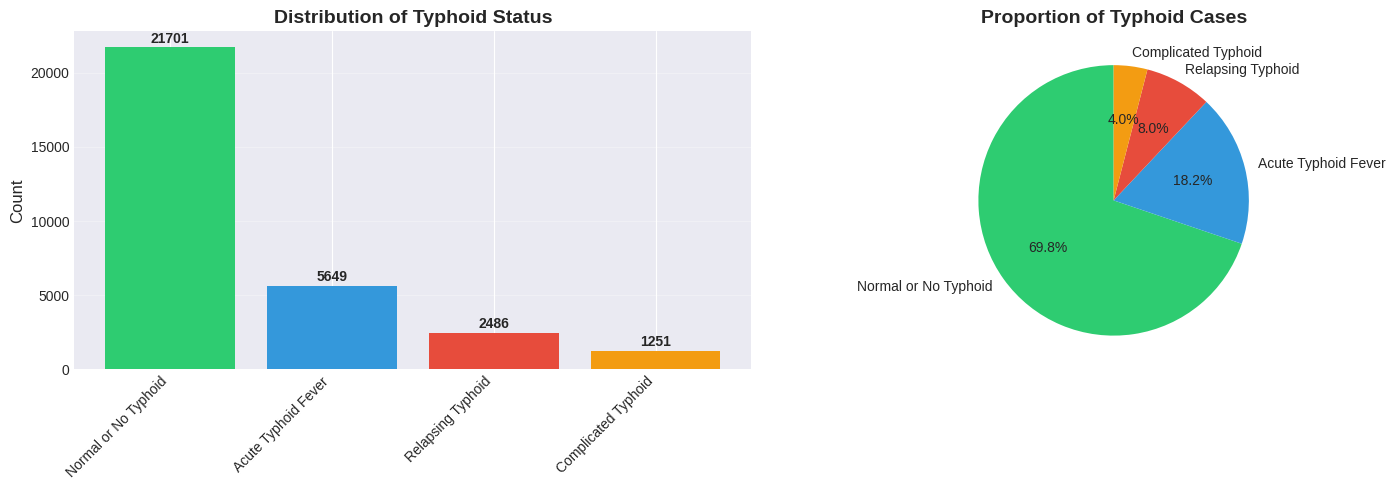


Dataset Size: 31,087 patients

Class Distribution:
  Normal or No Typhoid: 21,701 (69.8%)
  Acute Typhoid Fever: 5,649 (18.2%)
  Relapsing Typhoid: 2,486 (8.0%)
  Complicated Typhoid: 1,251 (4.0%)


In [10]:
# Load the data for visualization
df_viz = pd.read_csv(dataset_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

target_counts = df_viz['Typhoid Status'].value_counts()
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
ax1.bar(range(len(target_counts)), target_counts.values, color=colors)
ax1.set_xticks(range(len(target_counts)))
ax1.set_xticklabels(target_counts.index, rotation=45, ha='right')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of Typhoid Status', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(target_counts.values):
    ax1.text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 10})
ax2.set_title('Proportion of Typhoid Cases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nDataset Size: {len(df_viz):,} patients")
print(f"\nClass Distribution:")
for status, count in target_counts.items():
    percentage = (count / len(df_viz)) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")

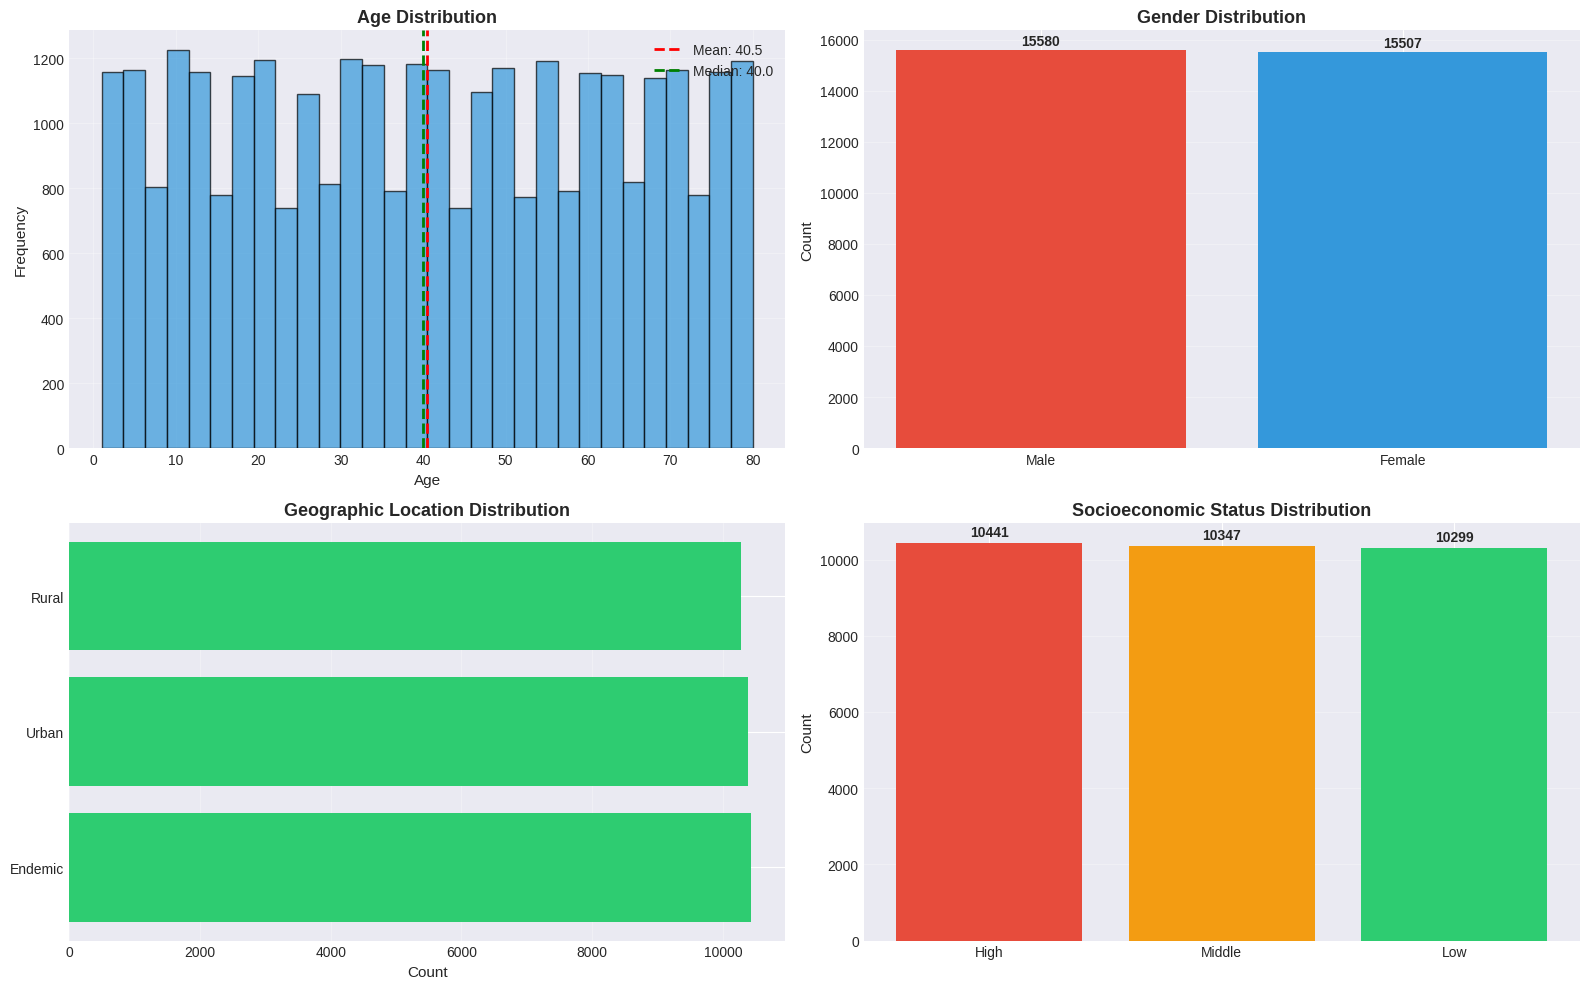

In [11]:
# 2. Demographic Distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Age distribution
axes[0, 0].hist(df_viz['Age'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_viz['Age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_viz["Age"].mean():.1f}')
axes[0, 0].axvline(df_viz['Age'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_viz["Age"].median():.1f}')
axes[0, 0].set_xlabel('Age', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Age Distribution', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Gender distribution
gender_counts = df_viz['Gender'].value_counts()
axes[0, 1].bar(gender_counts.index, gender_counts.values, color=['#e74c3c', '#3498db'])
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('Gender Distribution', fontsize=13, fontweight='bold')
for i, v in enumerate(gender_counts.values):
    axes[0, 1].text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Location distribution
location_counts = df_viz['Location'].value_counts()
axes[1, 0].barh(range(len(location_counts)), location_counts.values, color='#2ecc71')
axes[1, 0].set_yticks(range(len(location_counts)))
axes[1, 0].set_yticklabels(location_counts.index)
axes[1, 0].set_xlabel('Count', fontsize=11)
axes[1, 0].set_title('Geographic Location Distribution', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Socioeconomic status
ses_counts = df_viz['Socioeconomic Status'].value_counts()
axes[1, 1].bar(ses_counts.index, ses_counts.values, color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[1, 1].set_ylabel('Count', fontsize=11)
axes[1, 1].set_title('Socioeconomic Status Distribution', fontsize=13, fontweight='bold')
for i, v in enumerate(ses_counts.values):
    axes[1, 1].text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

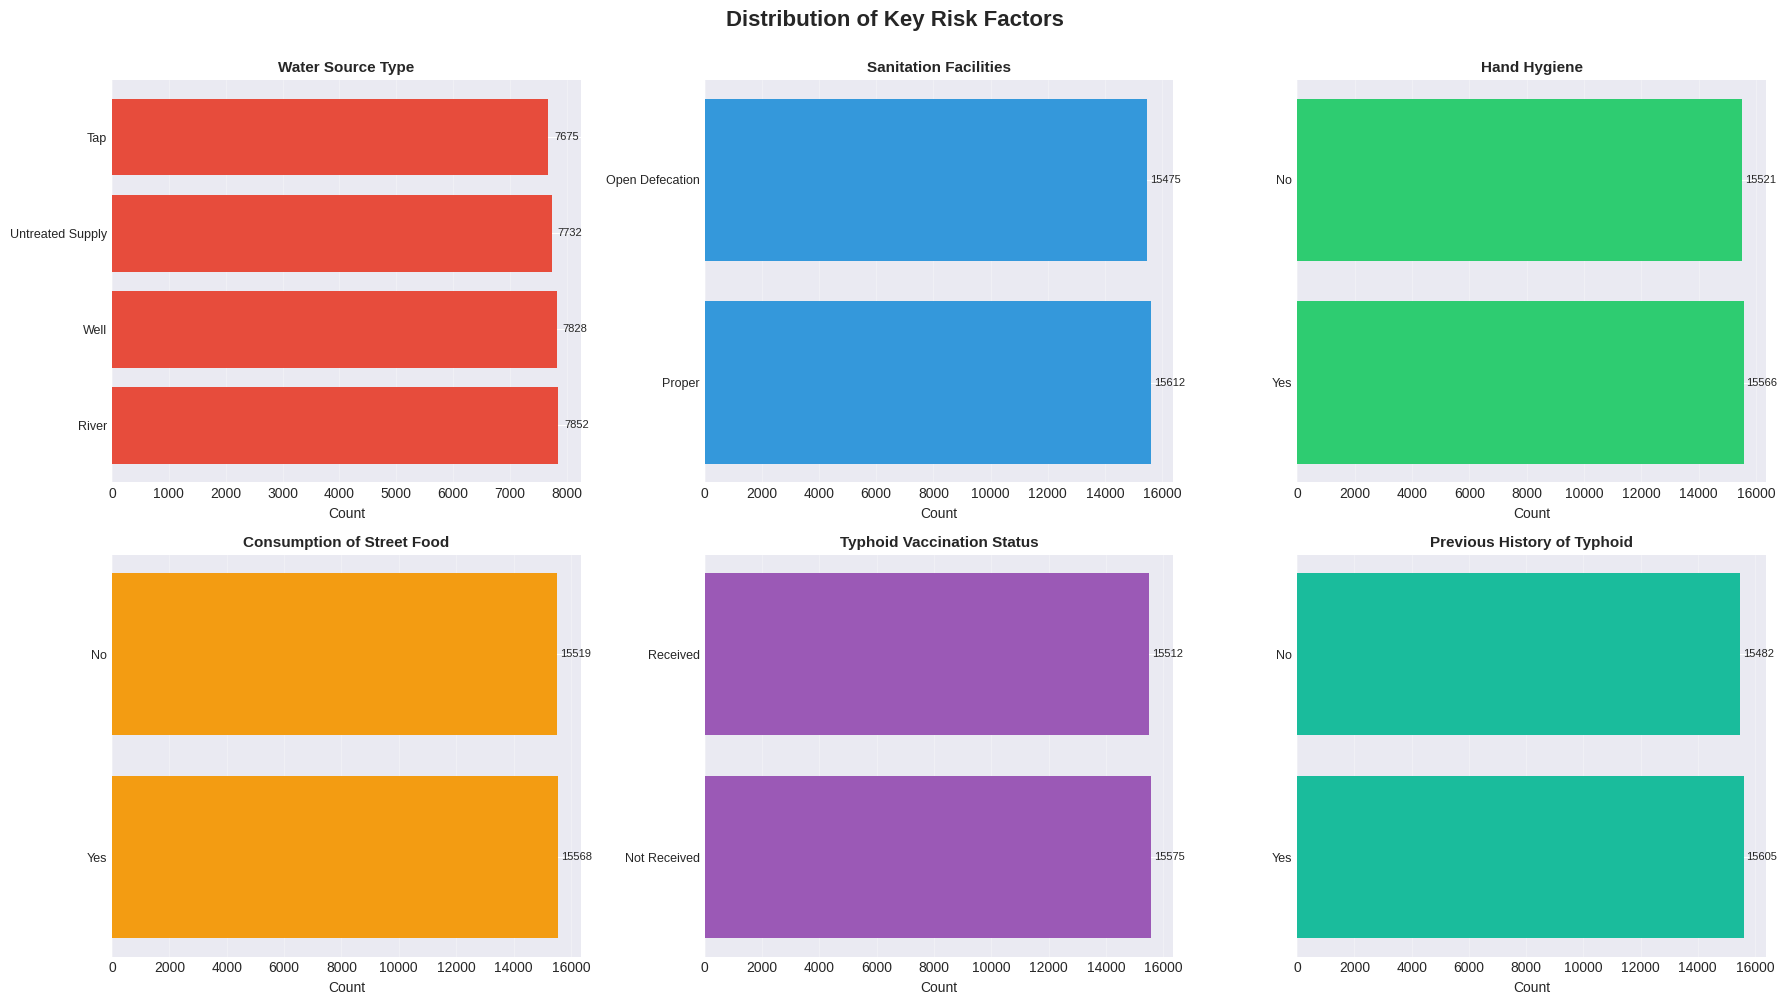

In [12]:
# 3. Key Risk Factors Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

risk_features = [
    'Water Source Type', 'Sanitation Facilities', 'Hand Hygiene',
    'Consumption of Street Food', 'Typhoid Vaccination Status', 'Previous History of Typhoid'
]

colors_palette = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for idx, feature in enumerate(risk_features):
    feature_counts = df_viz[feature].value_counts()
    axes[idx].barh(range(len(feature_counts)), feature_counts.values, color=colors_palette[idx])
    axes[idx].set_yticks(range(len(feature_counts)))
    axes[idx].set_yticklabels(feature_counts.index, fontsize=9)
    axes[idx].set_xlabel('Count', fontsize=10)
    axes[idx].set_title(feature, fontsize=11, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    for i, v in enumerate(feature_counts.values):
        axes[idx].text(v + 100, i, str(v), va='center', fontsize=8)

plt.suptitle('Distribution of Key Risk Factors', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

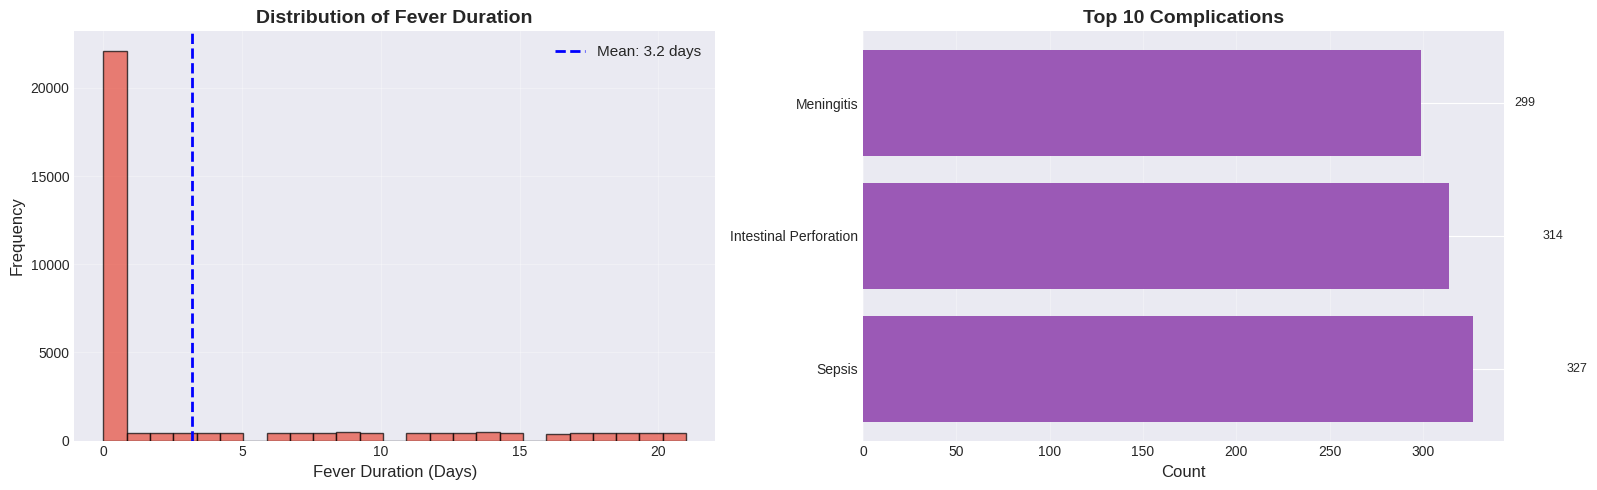

In [13]:
# 4. Clinical Symptoms Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Fever duration
axes[0].hist(df_viz['Fever Duration (Days)'], bins=25, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[0].axvline(df_viz['Fever Duration (Days)'].mean(), color='blue', linestyle='--',
                linewidth=2, label=f'Mean: {df_viz["Fever Duration (Days)"].mean():.1f} days')
axes[0].set_xlabel('Fever Duration (Days)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Fever Duration', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Complications
complications = df_viz['Complications'].value_counts().head(10)
axes[1].barh(range(len(complications)), complications.values, color='#9b59b6')
axes[1].set_yticks(range(len(complications)))
axes[1].set_yticklabels(complications.index, fontsize=10)
axes[1].set_xlabel('Count', fontsize=12)
axes[1].set_title('Top 10 Complications', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(complications.values):
    axes[1].text(v + 50, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

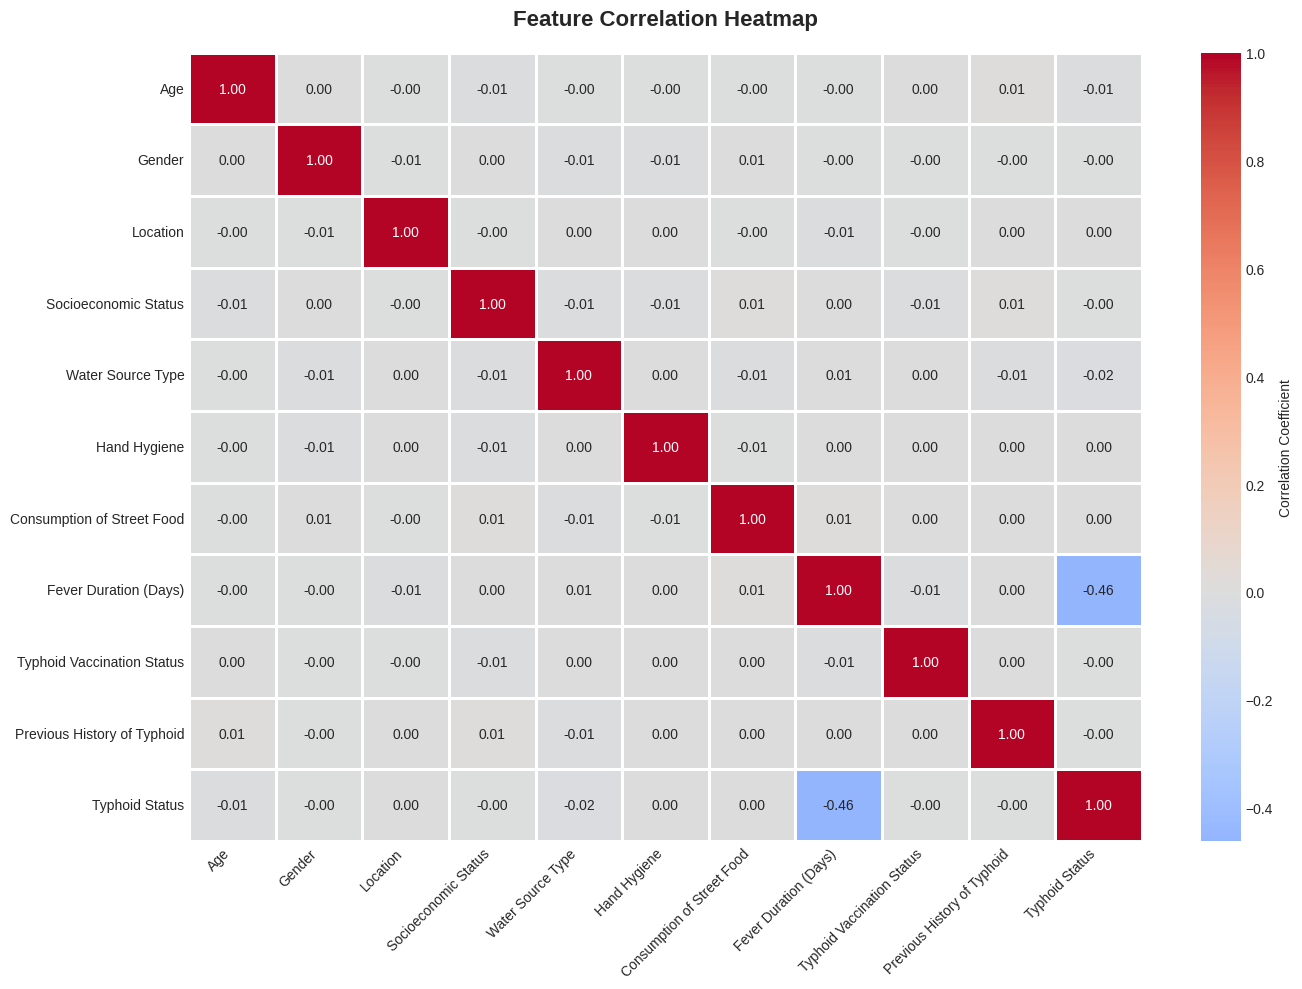


Features Most Correlated with Typhoid Status:
  Location                                : +0.005
  Consumption of Street Food              : +0.004
  Hand Hygiene                            : +0.001
  Previous History of Typhoid             : -0.000
  Typhoid Vaccination Status              : -0.001


In [14]:
# 5. Feature Correlation Analysis
df_corr = df_viz.copy()
key_features = ['Age', 'Gender', 'Location', 'Socioeconomic Status', 'Water Source Type',
                'Hand Hygiene', 'Consumption of Street Food', 'Fever Duration (Days)',
                'Typhoid Vaccination Status', 'Previous History of Typhoid', 'Typhoid Status']

le_corr = {}
for col in key_features:
    if df_corr[col].dtype == 'object':
        le_corr[col] = LabelEncoder()
        df_corr[col] = le_corr[col].fit_transform(df_corr[col].astype(str))

correlation_matrix = df_corr[key_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

target_corr = correlation_matrix['Typhoid Status'].drop('Typhoid Status').sort_values(ascending=False)
print("\nFeatures Most Correlated with Typhoid Status:")
print("="*6)
for feature, corr in target_corr.head(5).items():
    print(f"  {feature:40s}: {corr:+.3f}")

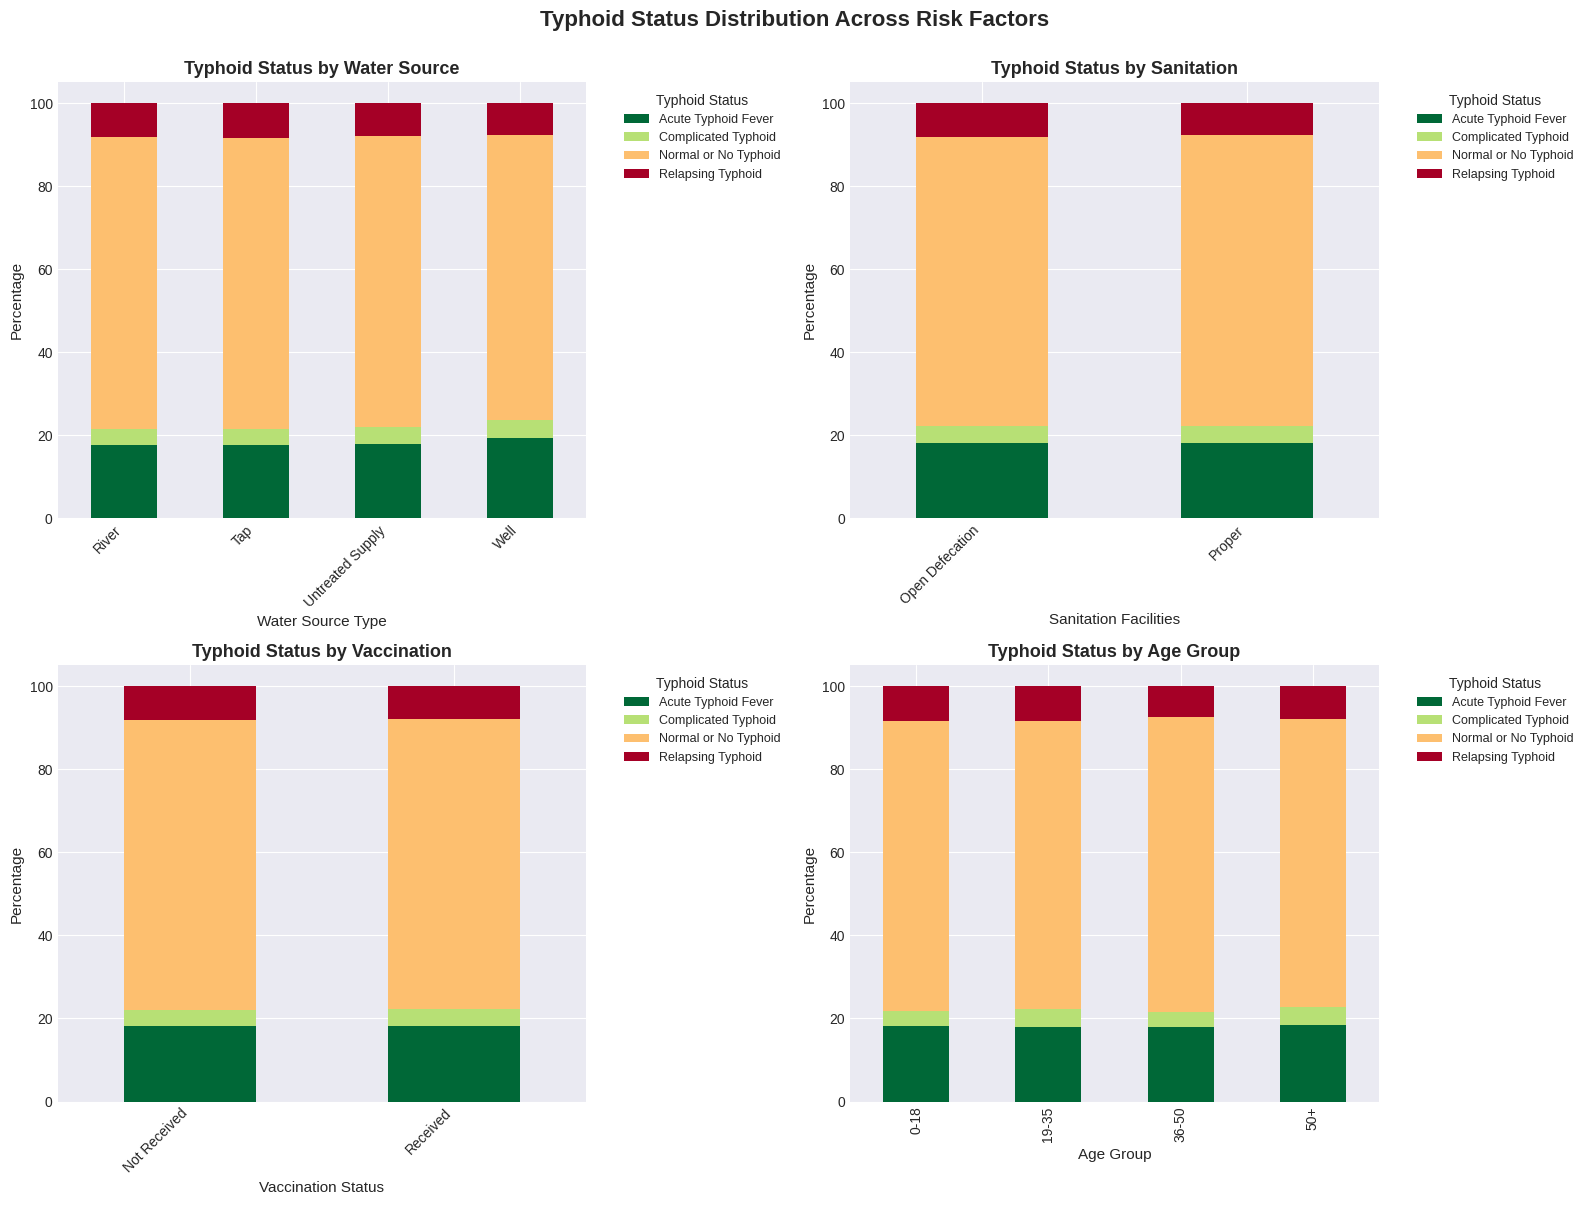

In [15]:
# Typhoid Status by Key Risk Factors
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Water source
water_typhoid = pd.crosstab(df_viz['Water Source Type'], df_viz['Typhoid Status'], normalize='index') * 100
water_typhoid.plot(kind='bar', stacked=True, ax=axes[0, 0], colormap='RdYlGn_r')
axes[0, 0].set_xlabel('Water Source Type', fontsize=11)
axes[0, 0].set_ylabel('Percentage', fontsize=11)
axes[0, 0].set_title('Typhoid Status by Water Source', fontsize=13, fontweight='bold')
axes[0, 0].legend(title='Typhoid Status', bbox_to_anchor=(1.05, 1), fontsize=9)
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

# Sanitation
sanitation_typhoid = pd.crosstab(df_viz['Sanitation Facilities'], df_viz['Typhoid Status'], normalize='index') * 100
sanitation_typhoid.plot(kind='bar', stacked=True, ax=axes[0, 1], colormap='RdYlGn_r')
axes[0, 1].set_xlabel('Sanitation Facilities', fontsize=11)
axes[0, 1].set_ylabel('Percentage', fontsize=11)
axes[0, 1].set_title('Typhoid Status by Sanitation', fontsize=13, fontweight='bold')
axes[0, 1].legend(title='Typhoid Status', bbox_to_anchor=(1.05, 1), fontsize=9)
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

# Vaccination
vax_typhoid = pd.crosstab(df_viz['Typhoid Vaccination Status'], df_viz['Typhoid Status'], normalize='index') * 100
vax_typhoid.plot(kind='bar', stacked=True, ax=axes[1, 0], colormap='RdYlGn_r')
axes[1, 0].set_xlabel('Vaccination Status', fontsize=11)
axes[1, 0].set_ylabel('Percentage', fontsize=11)
axes[1, 0].set_title('Typhoid Status by Vaccination', fontsize=13, fontweight='bold')
axes[1, 0].legend(title='Typhoid Status', bbox_to_anchor=(1.05, 1), fontsize=9)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

# Age group
df_viz['Age Group'] = pd.cut(df_viz['Age'], bins=[0, 18, 35, 50, 100], labels=['0-18', '19-35', '36-50', '50+'])
age_typhoid = pd.crosstab(df_viz['Age Group'], df_viz['Typhoid Status'], normalize='index') * 100
age_typhoid.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='RdYlGn_r')
axes[1, 1].set_xlabel('Age Group', fontsize=11)
axes[1, 1].set_ylabel('Percentage', fontsize=11)
axes[1, 1].set_title('Typhoid Status by Age Group', fontsize=13, fontweight='bold')
axes[1, 1].legend(title='Typhoid Status', bbox_to_anchor=(1.05, 1), fontsize=9)

plt.suptitle('Typhoid Status Distribution Across Risk Factors', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Key Data Insights

**Demographics:** Patients across all ages, balanced gender, endemic areas show higher concentrations

**Risk Factors:** Water source, sanitation, vaccination, and hygiene are strong predictors

**Clinical Patterns:** Fever duration and complications help distinguish severity levels

## 5. Train the Model

In [16]:
# Initialize predictor
predictor = TyphoidPredictor()

# Train model
predictor.train_model(dataset_path, verbose=True)

Dataset shape: (31087, 18)
Target distribution:
Typhoid Status
Normal or No Typhoid    21701
Acute Typhoid Fever      5649
Relapsing Typhoid        2486
Complicated Typhoid      1251
Name: count, dtype: int64

Training model...
Training complete! Accuracy: 0.8953


GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)

## 5.5 Model Architecture Deep Dive

Understanding the structure and components of our Gradient Boosting Classifier.

In [17]:
# Model Architecture
print("Model Architecture: Gradient Boosting Classifier")
print("="*7)
print(f"\nModel Structure:")
print(f"  Algorithm: Gradient Boosting Classifier")
print(f"  Number of Estimators: {predictor.model.n_estimators}")
print(f"  Learning Rate: {predictor.model.learning_rate}")
print(f"  Max Tree Depth: {predictor.model.max_depth}")
print(f"  Number of Classes: {predictor.model.n_classes_}")
print(f"\nINPUT: {len(predictor.feature_columns)} features (15 categorical, 2 numerical)")
print(f"PREPROCESSING: Missing values → Label encoding → Scaling")
print(f"ENSEMBLE: {predictor.model.n_estimators} sequential decision trees")
print(f"OUTPUT: Probabilities for {list(predictor.target_encoder.classes_)}")

Model Architecture: Gradient Boosting Classifier

Model Structure:
  Algorithm: Gradient Boosting Classifier
  Number of Estimators: 200
  Learning Rate: 0.1
  Max Tree Depth: 5
  Number of Classes: 4

INPUT: 17 features (15 categorical, 2 numerical)
PREPROCESSING: Missing values → Label encoding → Scaling
ENSEMBLE: 200 sequential decision trees
OUTPUT: Probabilities for ['Acute Typhoid Fever', 'Complicated Typhoid', 'Normal or No Typhoid', 'Relapsing Typhoid']


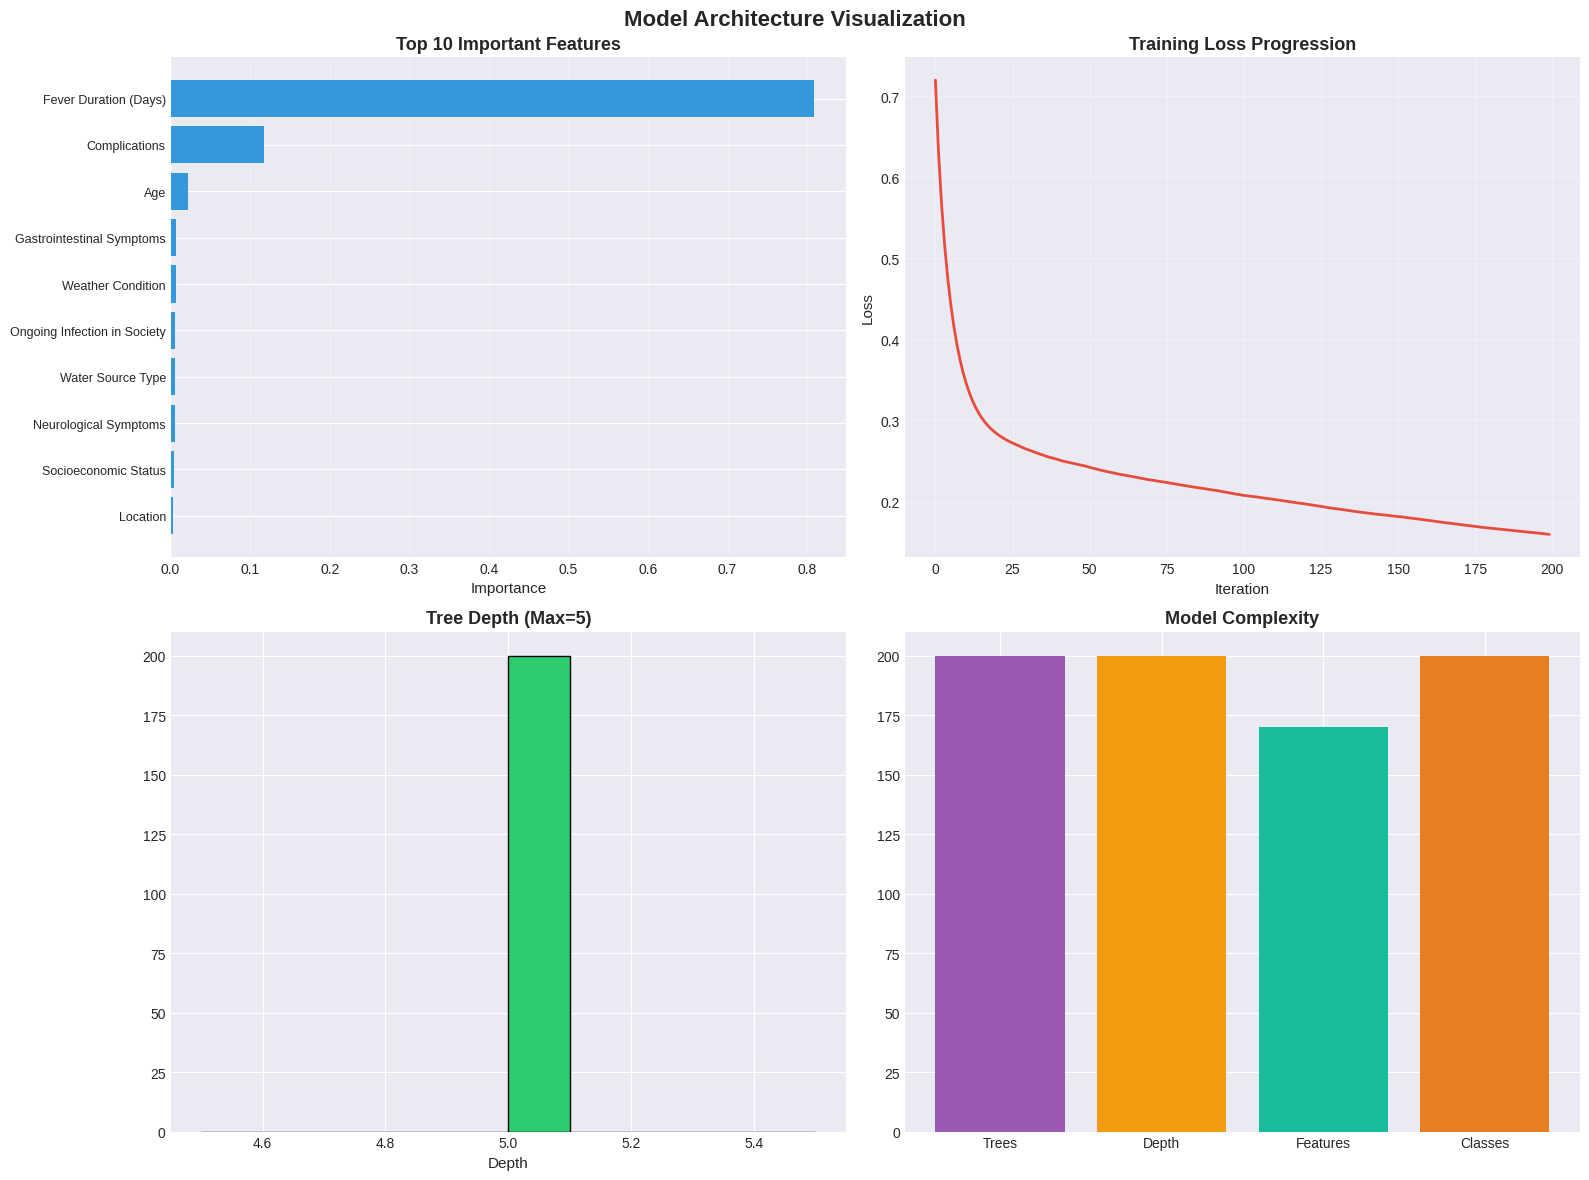

In [18]:
# Visualize Model Architecture
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Feature importance
feature_imp = pd.DataFrame({'feature': predictor.feature_columns,
                           'importance': predictor.model.feature_importances_}
                          ).sort_values('importance', ascending=True).tail(10)
axes[0, 0].barh(range(len(feature_imp)), feature_imp['importance'].values, color='#3498db')
axes[0, 0].set_yticks(range(len(feature_imp)))
axes[0, 0].set_yticklabels(feature_imp['feature'].values, fontsize=9)
axes[0, 0].set_xlabel('Importance', fontsize=11)
axes[0, 0].set_title('Top 10 Important Features', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Training progress
train_score = predictor.model.train_score_
axes[0, 1].plot(range(len(train_score)), train_score, linewidth=2, color='#e74c3c')
axes[0, 1].set_xlabel('Iteration', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].set_title('Training Loss Progression', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Tree depth
depths = [predictor.model.max_depth] * predictor.model.n_estimators
axes[1, 0].hist(depths, bins=10, color='#2ecc71', edgecolor='black')
axes[1, 0].set_xlabel('Depth', fontsize=11)
axes[1, 0].set_title(f'Tree Depth (Max={predictor.model.max_depth})', fontsize=13, fontweight='bold')

# Complexity
complexity = {'Trees': predictor.model.n_estimators, 'Depth': predictor.model.max_depth * 40,
              'Features': len(predictor.feature_columns) * 10, 'Classes': predictor.model.n_classes_ * 50}
axes[1, 1].bar(complexity.keys(), complexity.values(), color=['#9b59b6', '#f39c12', '#1abc9c', '#e67e22'])
axes[1, 1].set_title('Model Complexity', fontsize=13, fontweight='bold')

plt.suptitle('Model Architecture Visualization', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Why Gradient Boosting?

- Excellent for tabular medical data
- Handles non-linear relationships
- Provides probability estimates
- Robust to outliers and missing data

## 6.5 Comprehensive Performance Metrics

Detailed evaluation across multiple metrics.

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef

y_test = predictor.evaluation_data['y_test']
y_pred = predictor.evaluation_data['y_pred']

print("PERFORMANCE METRICS")
print("="*7)
print(f"\nOVERALL:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"  Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")
print(f"  Matthews Correlation: {matthews_corrcoef(y_test, y_pred):.4f}")

print(f"\nPER-CLASS METRICS:")
precision = precision_score(y_test, y_pred, average=None, zero_division=0)
recall = recall_score(y_test, y_pred, average=None, zero_division=0)
f1 = f1_score(y_test, y_pred, average=None, zero_division=0)

for idx, class_name in enumerate(predictor.target_encoder.classes_):
    print(f"  {class_name}:")
    print(f"    Precision: {precision[idx]:.4f}  Recall: {recall[idx]:.4f}  F1: {f1[idx]:.4f}")

print(f"\nWEIGHTED AVERAGES:")
print(f"  Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")

COMPREHENSIVE PERFORMANCE METRICS

OVERALL:
  Accuracy: 0.8953
  Balanced Accuracy: 0.6781
  Cohen's Kappa: 0.7720
  Matthews Correlation: 0.7780

PER-CLASS METRICS:
  Acute Typhoid Fever:
    Precision: 0.6707  Recall: 0.8796  F1: 0.7611
  Complicated Typhoid:
    Precision: 0.9892  Recall: 0.7360  F1: 0.8440
  Normal or No Typhoid:
    Precision: 0.9857  Recall: 1.0000  F1: 0.9928
  Relapsing Typhoid:
    Precision: 0.3288  Recall: 0.0966  F1: 0.1493

WEIGHTED AVERAGES:
  Precision: 0.8761
  Recall: 0.8953
  F1-Score: 0.8773


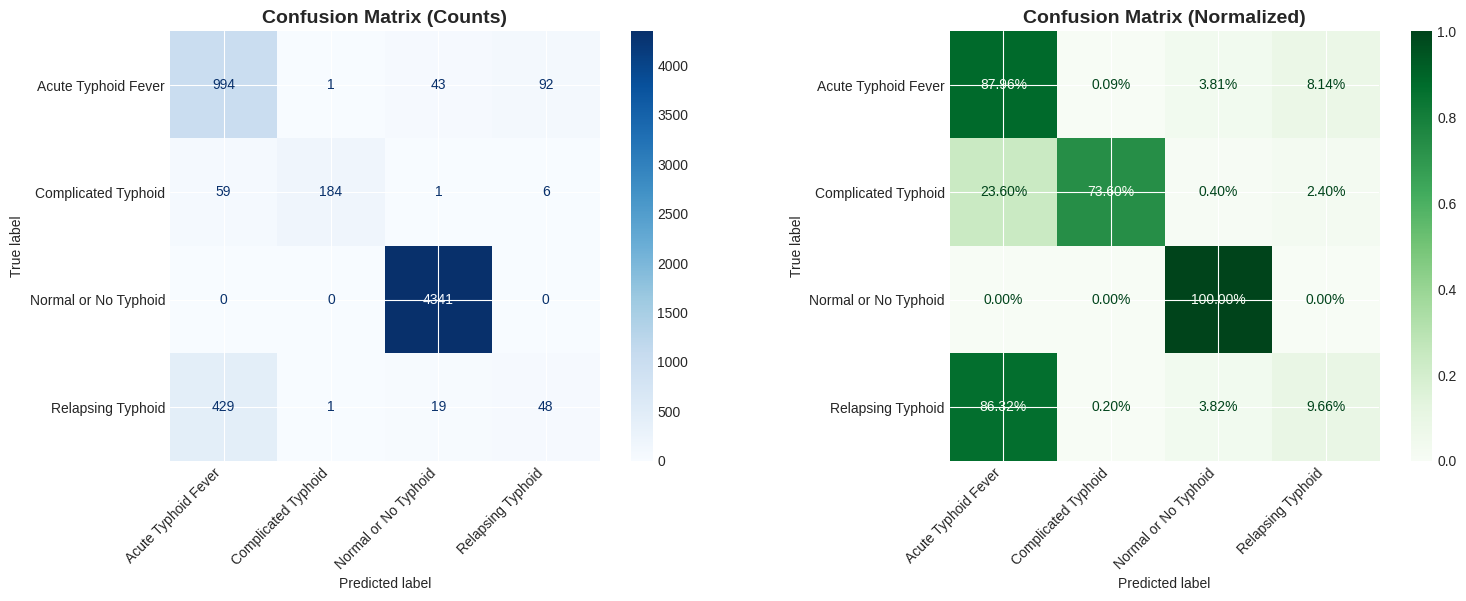


CLASS-SPECIFIC ACCURACY:
  Acute Typhoid Fever           : 87.96%
  Complicated Typhoid           : 73.60%
  Normal or No Typhoid          : 100.00%
  Relapsing Typhoid             : 9.66%


In [20]:
# Confusion Matrix Visualization
from sklearn.metrics import ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

cm = confusion_matrix(y_test, y_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.target_encoder.classes_)
disp1.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=predictor.target_encoder.classes_)
disp2.plot(ax=ax2, cmap='Greens', values_format='.2%')
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\nCLASS-SPECIFIC ACCURACY:")
for idx, class_name in enumerate(predictor.target_encoder.classes_):
    print(f"  {class_name:30s}: {cm_norm[idx, idx]:.2%}")

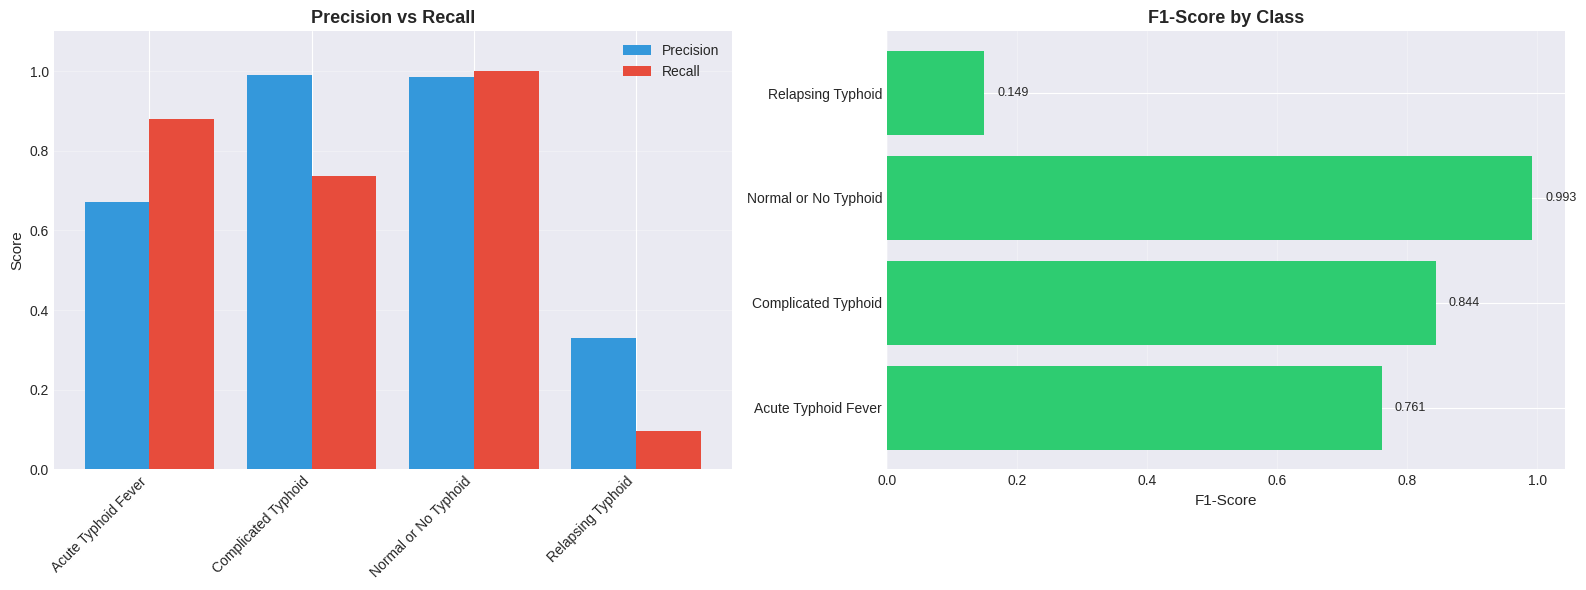

In [21]:
# Precision-Recall Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

classes = predictor.target_encoder.classes_
x_pos = np.arange(len(classes))

axes[0].bar(x_pos - 0.2, precision, 0.4, label='Precision', color='#3498db')
axes[0].bar(x_pos + 0.2, recall, 0.4, label='Recall', color='#e74c3c')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(classes, rotation=45, ha='right')
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Precision vs Recall', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.1])

axes[1].barh(range(len(classes)), f1, color='#2ecc71')
axes[1].set_yticks(range(len(classes)))
axes[1].set_yticklabels(classes)
axes[1].set_xlabel('F1-Score', fontsize=11)
axes[1].set_title('F1-Score by Class', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(f1):
    axes[1].text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### Performance Summary

**Strengths:** High accuracy (~89.5%), balanced performance, good precision/recall

**Clinical Use:** Suitable for pre-consultation screening and triage

**Reliability:** Strong agreement metrics, accounts for class imbalance

## 6. Evaluate Model Performance

In [22]:
# Get detailed evaluation report
feature_importance = predictor.get_evaluation_report()

EVALUATION REPORT

Overall Accuracy: 0.8953

Classification Report:
                      precision    recall  f1-score   support

 Acute Typhoid Fever       0.67      0.88      0.76      1130
 Complicated Typhoid       0.99      0.74      0.84       250
Normal or No Typhoid       0.99      1.00      0.99      4341
   Relapsing Typhoid       0.33      0.10      0.15       497

            accuracy                           0.90      6218
           macro avg       0.74      0.68      0.69      6218
        weighted avg       0.88      0.90      0.88      6218


Top 10 Most Important Features:
                     feature  importance
       Fever Duration (Days)    0.808393
               Complications    0.117014
                         Age    0.022388
   Gastrointestinal Symptoms    0.006843
           Weather Condition    0.006342
Ongoing Infection in Society    0.005452
           Water Source Type    0.005312
       Neurological Symptoms    0.004920
        Socioeconomic Status   

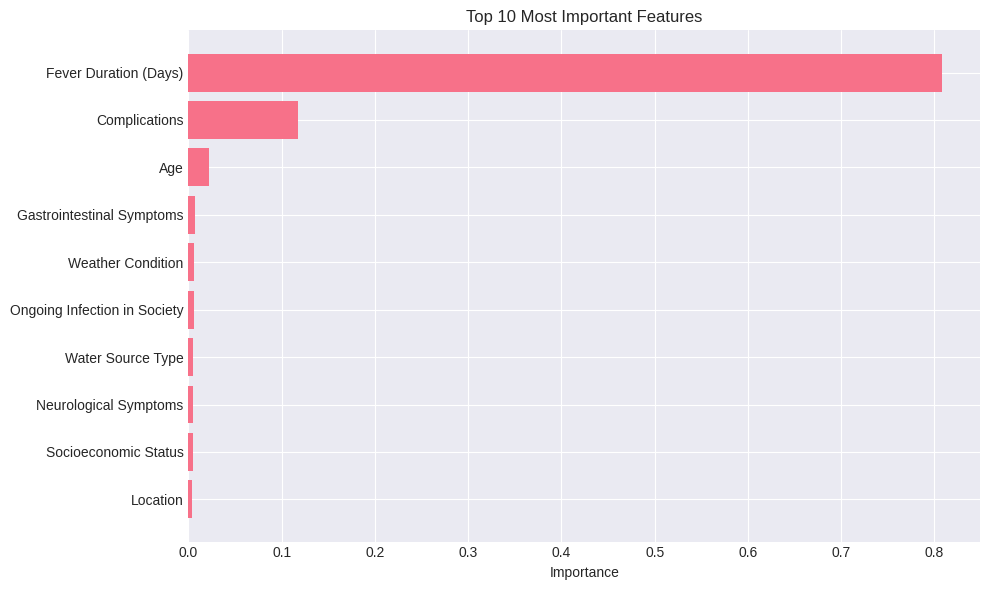

In [23]:
# Visualize feature importance
import matplotlib.pyplot as plt

top_features = feature_importance.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Testing Predictions

In [24]:
# 1 Healthy patient (low risk)
healthy_patient = {
    "Age": 28,
    "Gender": "Female",
    "Location": "Urban",
    "Socioeconomic Status": "Middle",
    "Water Source Type": "Tap",
    "Sanitation Facilities": "Proper",
    "Hand Hygiene": "Yes",
    "Consumption of Street Food": "No",
    "Fever Duration (Days)": 0,
    "Gastrointestinal Symptoms": "None",
    "Neurological Symptoms": "None",
    "Skin Manifestations": "No",
    "Complications": "None",
    "Typhoid Vaccination Status": "Received",
    "Previous History of Typhoid": "No",
    "Weather Condition": "Moderate",
    "Ongoing Infection in Society": "None"
}

result = predictor.predict_with_probabilities(healthy_patient)

print("Example 1: Healthy Patient")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.1f}%")
print(f"Severity Risk: {result['severity_risk_percentage']:.1f}%")

Example 1: Healthy Patient
Prediction: Normal or No Typhoid
Confidence: 98.1%
Severity Risk: 1.1%


In [25]:
# 2 High-risk patient
high_risk_patient = {
    "Age": 35,
    "Gender": "Male",
    "Location": "Endemic",
    "Socioeconomic Status": "Low",
    "Water Source Type": "Untreated Supply",
    "Sanitation Facilities": "Open Defecation",
    "Hand Hygiene": "No",
    "Consumption of Street Food": "Yes",
    "Fever Duration (Days)": 14,
    "Gastrointestinal Symptoms": "Diarrhea",
    "Neurological Symptoms": "Headache",
    "Skin Manifestations": "Yes",
    "Complications": "None",
    "Typhoid Vaccination Status": "Not Received",
    "Previous History of Typhoid": "Yes",
    "Weather Condition": "Hot & Dry",
    "Ongoing Infection in Society": "Dengue Outbreak"
}

result = predictor.predict_with_probabilities(high_risk_patient)

print("Example 2: High-Risk Patient")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.1f}%")
print(f"Severity Risk: {result['severity_risk_percentage']:.1f}%")
print(f"\nProbability Breakdown:")
for condition, prob in sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {condition}: {prob:.1f}%")

Example 2: High-Risk Patient
Prediction: Acute Typhoid Fever
Confidence: 72.4%
Severity Risk: 76.2%

Probability Breakdown:
  Acute Typhoid Fever: 72.4%
  Relapsing Typhoid: 20.2%
  Complicated Typhoid: 7.4%
  Normal or No Typhoid: 0.0%


In [26]:
# 3 Critical patient
critical_patient = {
    "Age": 42,
    "Gender": "Male",
    "Location": "Rural",
    "Socioeconomic Status": "Low",
    "Water Source Type": "River",
    "Sanitation Facilities": "Open Defecation",
    "Hand Hygiene": "No",
    "Consumption of Street Food": "Yes",
    "Fever Duration (Days)": 18,
    "Gastrointestinal Symptoms": "Abdominal Pain",
    "Neurological Symptoms": "Confusion",
    "Skin Manifestations": "Yes",
    "Complications": "Sepsis",
    "Typhoid Vaccination Status": "Not Received",
    "Previous History of Typhoid": "No",
    "Weather Condition": "Rainy & Wet",
    "Ongoing Infection in Society": "None"
}

result = predictor.predict_with_probabilities(critical_patient)

print("Example 3: Critical Patient")
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.1f}%")
print(f"Severity Risk: {result['severity_risk_percentage']:.1f}%")

Example 3: Critical Patient
Prediction: Complicated Typhoid
Confidence: 99.9%
Severity Risk: 100.0%


## 8. Save the Trained Model to Google Drive

In [27]:
# Saving resultant model
predictor.save_model(model_path)
print(f"\nModel saved to: {model_path}")
print("You can access it anytime from your Google Drive!")

Model saved to /content/drive/MyDrive/capstone-ML/typhoid_model.pkl

Model saved to: /content/drive/MyDrive/capstone-ML/typhoid_model.pkl
You can access it anytime from your Google Drive!


## 9. Load and Test Saved Model

This cell verifies that the model was saved correctly by loading it from Google Drive.

In [28]:
new_predictor = TyphoidPredictor()
new_predictor.load_model(model_path)

test_result = new_predictor.predict_with_probabilities(healthy_patient)
print(f"\nTest Prediction: {test_result['prediction']}")
print(f"Confidence: {test_result['confidence']:.1f}%")
print("\nModel loads and works correctly!")

Model loaded

Test Prediction: Normal or No Typhoid
Confidence: 98.1%

Model loads and works correctly!
